In [375]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import root_numpy as rtnp

version_id = 'v1'
SEED = 42

In [21]:
# get h5 datasets
data_path = "data/background/*_data.h5"
signal_path = "data/signal/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.25

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(**norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.2% (2504) train
	3.2% (837) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (29023) train
	38.0% (9818) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (14251) train
	18.4% (4748) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.7% (19123) train
	24.2% (6254) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.2% (7151) train
	9.4% (2426) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.1% (5510) train
	6.9% (1771) test
	7.0% (7281) background
	5.1% (2541) signal


### Make autoencoder
Here we have some characterizing parameters for the VAE which can be messed with to try and acheive better results.

In [458]:
l1_amount = None          # l1 regularization amount
KL_loss_weight = 1.8      # according to olmo's paper
input_dim = 7              # num. HLF
interm_dim = 50            # num. interm nodes
neck_dim = 3              # num. latent variables
kernel_max_norm = None     # kernel max norm amount

name = "bn_{0}_{1}".format(neck_dim, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/"

Loss functions and helpers

In [459]:
import keras.backend as K
import keras

def isrlu(args, min_value = 5e-3):
    """ranges from (0, +inf), with relu behavior at x > 0 and exponential decay at x < 0"""
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1+K.square(args))))

def sample_from_gauss(args):
    """reparam trick for VAE"""
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + z_sigma * epsilon

def make_zero(x):
    """lambda zero function, for forward pass of priors from x variable"""
    return 0.*x

def KL_loss(mu, sigma, mu_prior, sigma_prior):
    """KL loss from mu, sigma, and their priors"""
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

def reconstruction_probability(x, mu, sigma):
    """calculate gaussian -log likelihood across all variables and sum"""
    z_score = K.tf.divide(x - mu, sigma)
    single = - K.log(1./(sigma*np.sqrt(2.*np.pi)))/np.log(np.e) + 0.5*K.square(z_score)
    return K.sum(single, axis=-1)

class recon_prob_wrapper_layer(keras.layers.Layer):
    """Wrapper for recon. prob. function. 
    Outputs reconstruction probability of gaussians for vae
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(recon_prob_wrapper_layer, self).__init__(**kwargs)
    
    def call(self, inputs):
        x, mu, sigma = inputs
        return reconstruction_probability(x, mu, sigma)
    
class KL_loss_wrapper_layer(keras.layers.Layer):
    """Wrapper for KL_loss function. 
    Layer which outputs KL loss according the the function defined above
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(KL_loss_wrapper_layer, self).__init__(**kwargs)
    
    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss(mu, sigma, mu_prior, sigma_prior)
    
def Identity(y_train, vae_output):
    """identity loss, takes into account ONLY the VAE output (vae output should actually be the 
    calculated loss functions!)"""
    return K.mean(vae_output)

### Define layers
Define layers to setup layer architecture for later

In [460]:
import keras.backend as K
import keras

# define layers
input_layer = keras.layers.Input(shape=(input_dim,), name="input")

intermediate_layer_enc1 = keras.layers.Dense(interm_dim, name="hidden_enc1")
intermediate_layer_enc2 = keras.layers.Dense(intermediate_dim, activation='relu', kernel_constraint=max_norm(kernel_max_norm), name='hidden_enc2')

z_mu_layer = keras.layers.Dense(neck_dim, name='z_mu')
z_sigma_pre_layer = keras.layers.Dense(neck_dim, name="z_sigma_pre")
z_sigma_layer = keras.layers.Lambda(isrlu, name="z_sigma")

z_latent_layer = keras.layers.Lambda(sample_from_gauss, name="latent_sampling")
z_input_layer = keras.layers.Input(shape=(neck_dim,), name="z_input_layer")

intermediate_layer_dec1 = keras.layers.Dense(interm_dim, name="hidden_dec1", kernel_constraint=max_norm(kernel_max_norm))
intermediate_layer_dec2 = keras.layers.Dense(interm_dim, name="hidden_dec2")

output_sigma_pre_layer = keras.layers.Dense(input_dim, name="output_sigma_pre", activation="linear")
output_sigma_layer = keras.layers.Lambda(isrlu, name="output_sigma")
output_mu_layer = keras.layers.Dense(input_dim, name="output_mu", activation="linear")

# prior layers for KL divergence
fixed_input_layer = keras.layers.Lambda(make_zero, name="fixed_input")
prior_layer = keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer='ones', trainable=False, name='prior')
prior_mu_layer = keras.layers.Dense(neck_dim, kernel_initializer='zeros', bias_initializer='zeros', trainable=True, name='prior_mu')
prior_sigma_pre_layer = keras.layers.Dense(neck_dim, kernel_initializer='zeros', bias_initializer='ones', trainable=True, name='prior_sigma_pre')
prior_sigma_layer = keras.layers.Lambda(isrlu, name='prior_sigma')

In [461]:
## INPUT to encoder
aux = intermediate_layer_enc1(input_layer)   # first intermediate layer
aux = intermediate_layer_enc2(aux)

z_mu = z_mu_layer(aux)                    # z mu layer
z_sigma = z_sigma_layer(z_sigma_pre_layer(aux)) # z sigma layer (with correction)
z_latent = z_latent_layer([z_mu, z_sigma])      # z latent layer (draw from latent distribution, zmu/zsigma)

## INPUT to decoder
aux = intermediate_layer_dec1(z_latent) # z_input_layer if you want a decoder
aux = intermediate_layer_dec2(aux)
out_mu = output_mu_layer(aux)
out_sigma = output_sigma_layer(output_sigma_pre_layer(aux))
## OUTPUT to decoder

# reparameterization trick!
fixed_input = fixed_input_layer(input_layer)        # fixed input layer (no training)
prior = prior_layer(fixed_input)                    # prior layer (one node, all constant)
prior_mu = prior_mu_layer(prior)                    # mu layer (all ones, trainable)
prior_sigma = prior_sigma_layer(prior_sigma_pre_layer(prior)) # sigma layer (all geq zero, trainable)


# # make encoder/decoder models
# encoder = keras.models.Model(inputs=input_layer, outputs=z_latent, name="encoder")
# decoder = keras.models.Model(inputs=z_input_layer, outputs=[out_mu, out_sigma], name="decoder")

# reconstruction probability: create from input layer, as well as outputs of decoder (mu/sigma out)
reco_prob_out = recon_prob_wrapper_layer(name="reconstructed_probability")([input_layer, out_mu, out_sigma])
# KL loss: create from zed mu/sigma, as well as prior variables
KL_loss_out = KL_loss_wrapper_layer(name="KL_loss_layer")([z_mu, z_sigma, prior_mu, prior_sigma])

# autoencoder made from x-input to loss outputs
vae = keras.models.Model(inputs=input_layer, outputs=[KL_loss_out, reco_prob_out])

vae.compile(optimizer="adam", loss=[Identity, Identity], loss_weights=[KL_loss_weight, 1.])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 7)            0                                            
__________________________________________________________________________________________________
hidden_enc1 (Dense)             (None, 50)           400         input[0][0]                      
__________________________________________________________________________________________________
hidden_enc2 (Dense)             (None, 50)           2550        hidden_enc1[0][0]                
__________________________________________________________________________________________________
z_sigma_pre (Dense)             (None, 3)            153         hidden_enc2[0][0]                
__________________________________________________________________________________________________
z_mu (Dens

### Define and build models

In [478]:
history = vae.fit(
    x=train_norm.data,
    y=[np.zeros((train_norm.shape[0], neck_dim)),np.zeros(train_norm.shape)],
    validation_data=(test_norm.data, [np.zeros((test_norm.shape[0], neck_dim)),np.zeros(test_norm.shape)]),
    epochs=20,
    batch_size=256
)

Train on 77562 samples, validate on 25854 samples
Epoch 1/20
77562/77562 [==============================] - 2s 29us/step - loss: 6.4565 - KL_loss_layer_loss: 3.6979 - reconstructed_probability_loss: -0.1997 - val_loss: 6.5083 - val_KL_loss_layer_loss: 3.6786 - val_reconstructed_probability_loss: -0.1132
Epoch 2/20
77562/77562 [==============================] - 2s 29us/step - loss: 6.4777 - KL_loss_layer_loss: 3.6592 - reconstructed_probability_loss: -0.1088 - val_loss: 6.5004 - val_KL_loss_layer_loss: 3.6443 - val_reconstructed_probability_loss: -0.0594
Epoch 3/20
77562/77562 [==============================] - 2s 28us/step - loss: 6.4120 - KL_loss_layer_loss: 3.6763 - reconstructed_probability_loss: -0.2054 - val_loss: 6.3693 - val_KL_loss_layer_loss: 3.7270 - val_reconstructed_probability_loss: -0.3392
Epoch 4/20
77562/77562 [==============================] - 2s 28us/step - loss: 6.4029 - KL_loss_layer_loss: 3.7258 - reconstructed_probability_loss: -0.3035 - val_loss: 6.3417 - val_KL_

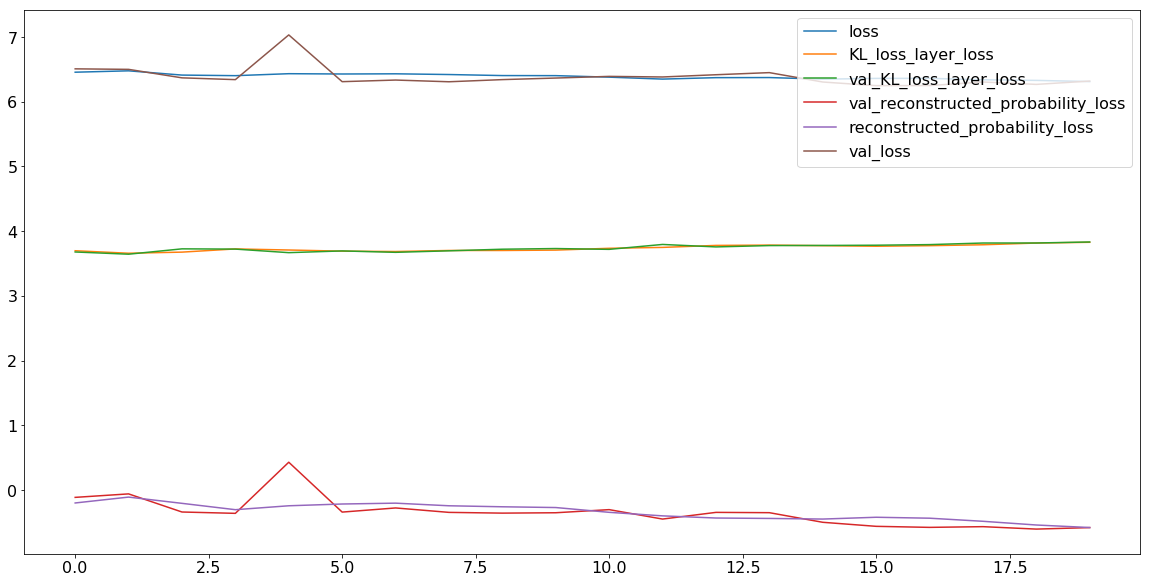

In [479]:
plt.figure(figsize=(20,10))
# styles = ['-', '*', 'o']
for i,(name,data) in enumerate(history.history.items()):
    plt.plot(data, label=name,)
plt.legend()
plt.show()

Plotting dim 0 ...


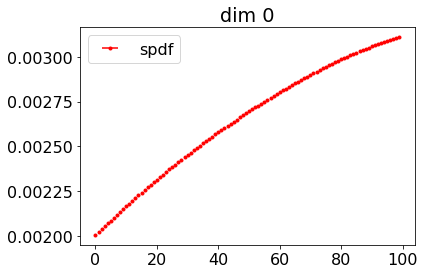

Plotting dim 1 ...


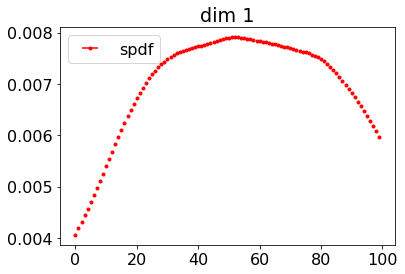

In [480]:
import ROOT as rt

prior_dumper = keras.models.Model(inputs=input_layer, outputs=[z_mu, z_sigma])
aux = prior_dumper.predict(np.zeros((1, original_dim)))
mu_prior = aux[0][0]
sigma_prior = aux[1][0]
import matplotlib


histos = []
canvases = []
N_bins = 100
rt.gStyle.SetOptTitle(0)

for kk in range(latent_dim):
    print 'Plotting dim', kk, '...'
#     canvas = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)
#     canvas.SetLeftMargin(0.16)
#     canvas.SetBottomMargin(0.16)
#     canvas.SetRightMargin(0.02)
#     canvas.SetTopMargin(0.02)

    l_bound = mu_prior[kk] - 6*sigma_prior[kk]
    u_bound = mu_prior[kk] + 6*sigma_prior[kk]
    bin_width = (u_bound - l_bound)/N_bins
    z = np.arange(l_bound, u_bound, bin_width)
    
    bin_content = sum_of_gaussians(z, x_val_encoded[0, :, kk], x_val_encoded[1, :, kk])*bin_width
    
#     plt.errorbar(centers, content, xerr=width/2., yerr=np.sqrt(content), fmt='.b', label='input')
    plt.errorbar(range(len(bin_content)), bin_content, xerr=width/2., fmt='.r', label='spdf')
    plt.title("dim {}".format(kk))
    plt.legend()
    plt.show()
    
#     print '\t SMMix coverage: {:.3f}'.format(np.sum(bin_content))
#     h = rt.TH1F('h_SMMix_{}'.format(kk), 'SMMix', N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
#     for i,c in enumerate(bin_content): 
#         h.SetBinContent(i+1, c)
#     h.GetYaxis().SetRangeUser(1e-5, 0.9)
#     h.SetStats(0)
#     h.SetLineWidth(0)
#     h.SetFillColorAlpha(rt.kGreen+2, 0.7)
#     h.SetFillStyle(3001)
    
#     h.SetXTitle('z_{'+str(kk)+'}')
#     h.GetXaxis().SetTitleSize(0.06)
#     h.GetXaxis().SetLabelSize(0.06)
#     h.SetYTitle('p.d.f.')
#     h.GetYaxis().SetTitleSize(0.06)
#     h.GetYaxis().SetTitleOffset(1.16)
#     h.GetYaxis().SetLabelSize(0.06)    
    
#     h.Draw('Bar')
#     histos.append(h)


# #     colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
# #     # fill
# #     for i, n in enumerate(x_sig.keys()):
# #         bin_content = sum_of_gaussians(z, x_sig_encoded[n][0, :, kk], x_sig_encoded[n][1, :, kk])*bin_width
# #         print '\t {} coverage: {:.3f}'.format(n, np.sum(bin_content))
# #         h = rt.TH1F('h_{}_{}'.format(n, kk), n, N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
# #         for j,c in enumerate(bin_content): 
# #             h.SetBinContent(j+1, c)

# #         h.SetStats(0)
# #         h.SetLineColor(colors[i])
# #         h.SetLineWidth(2)
# #         h.Draw('SAME')
# #         histos.append(h)
#     leg = canvas.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
        
# #     line = rt.TLine()
# #     line.SetLineWidth(2)
# #     line.SetLineStyle(9)
# #     line.SetLineColor(9)
# #     l = line.DrawLine(mu_prior[kk], 1e-5, mu_prior[kk], 0.9)
# #     leg.AddEntry(l, 'Prior Mean', 'l')
# #     line.SetLineColor(40)
# #     l = line.DrawLine(mu_prior[kk]-sigma_prior[kk], 1e-5, mu_prior[kk]-sigma_prior[kk], 0.9)
# #     leg.AddEntry(l, 'Prior Sigma', 'l')
    
# #     line.DrawLine(mu_prior[kk]+sigma_prior[kk], 1e-5, mu_prior[kk]+sigma_prior[kk], 0.9)
    
#     canvas.SetGrid()
#     canvas.SetLogy()
#     canvas.Draw()
#     canvas.Update()
#     canvases.append(canvas)
    
# # fout = rt.TFile('plots/all-in-one_v'+VAEversion+'_Zpdf.root', 'RECREATE')
# # for obj in canvases + histos:
# #     obj.Write()

# # fout.Close()

In [481]:
autoencoder = keras.models.Model(inputs=input_layer, outputs=[out_mu, out_sigma])
pars_ae = autoencoder.predict(train_norm.data)

jetEta


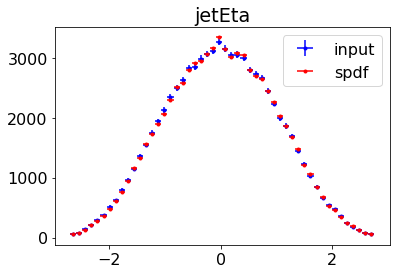

jetPhi


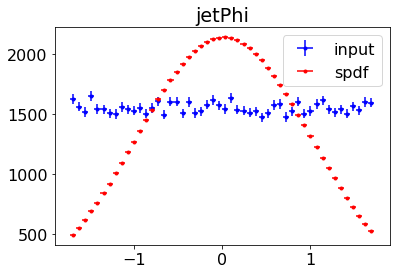

jetPt


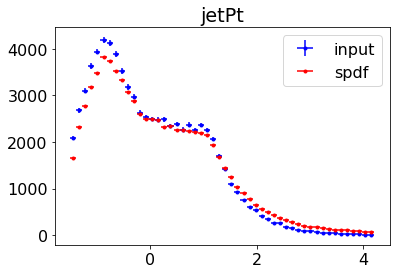

jetChargedFraction


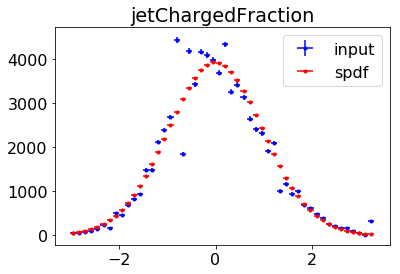

jetPTD


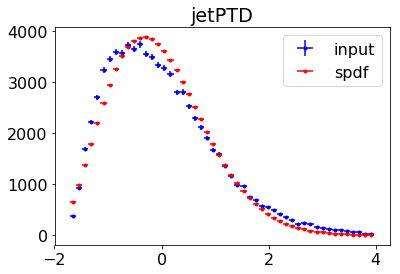

jetAxis2


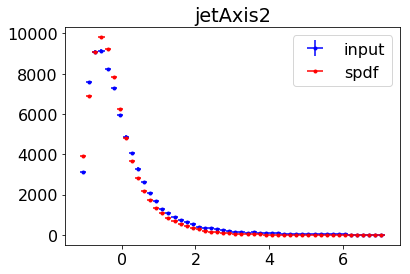

jetEnergy


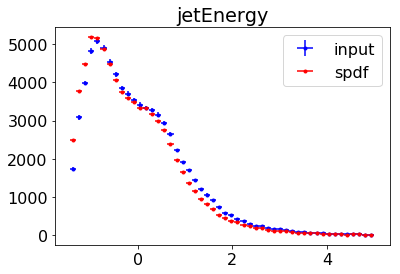

In [482]:
def sum_of_gaussians(x, mu, sigma):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu) / sigma
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma*np.sqrt(2.*np.pi))
    return np.sum(single_gaus_val, axis=1) / mu.shape[0]

bins = 50

contents = {}
for i, name in enumerate(train_norm.headers):
    print name
    contents[name] = []
    x_aux = train_norm.data[:,i]
    hrange = (np.percentile(x_aux, 0.1), np.percentile(x_aux, 99.9))
    content, edges = np.histogram(x_aux, bins=bins, range=hrange)
    centers = 0.5*(edges[1:] + edges[:-1])
    width = centers[1] - centers[0]
    
    mu = pars_ae[0][:, i]
    sigma = pars_ae[1][:, i]
    bin_content = np.sum(content)*width*sum_of_gaussians(centers, mu, sigma)

    plt.errorbar(centers, content, xerr=width/2., yerr=np.sqrt(content), fmt='.b', label='input')
    plt.errorbar(centers, bin_content, xerr=width/2., fmt='.r', label='spdf')
#     plt.hist(mu, histtype='step', bins=bins)
    plt.title(name)
    plt.legend()
    plt.show()

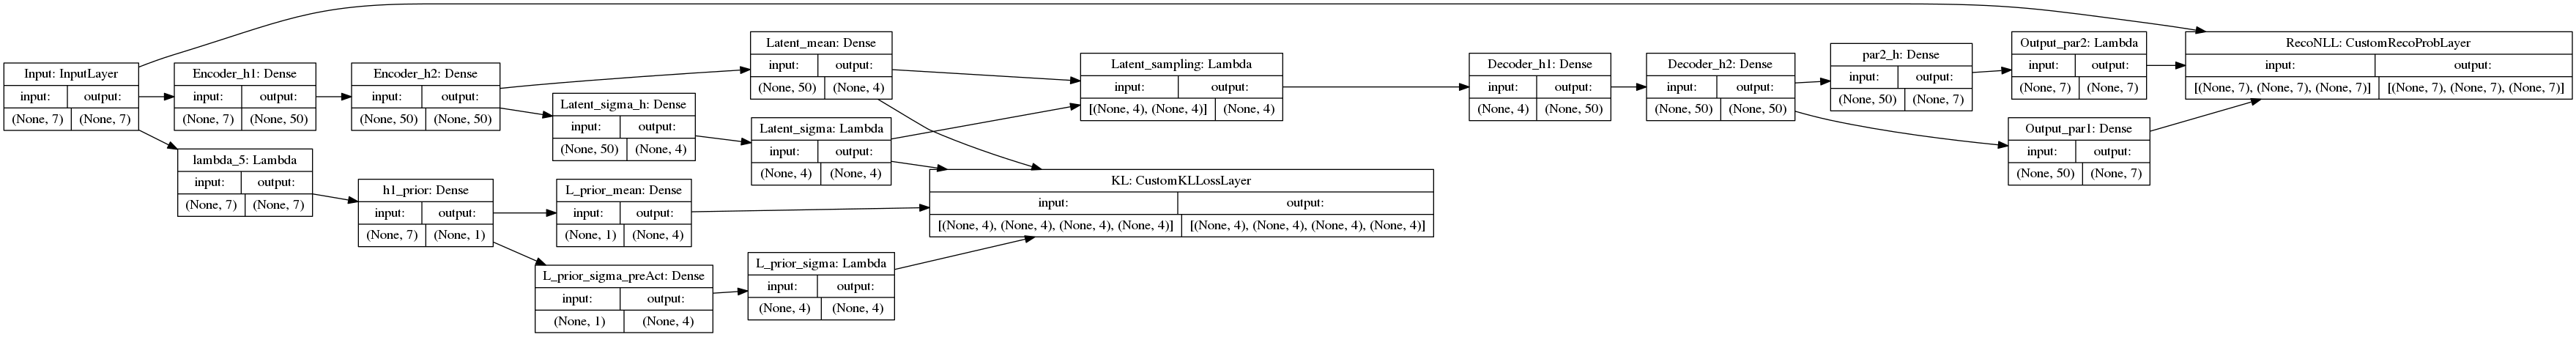

In [317]:
keras.utils.vis_utils.plot_model(vae, show_shapes=True, rankdir='LR') #.utils.plot_model(encoder)
from IPython.display import Image
Image("model.png")
# keras.utils.plot_model(decoder)

In [431]:
signal_norm.shape

(49516, 7)

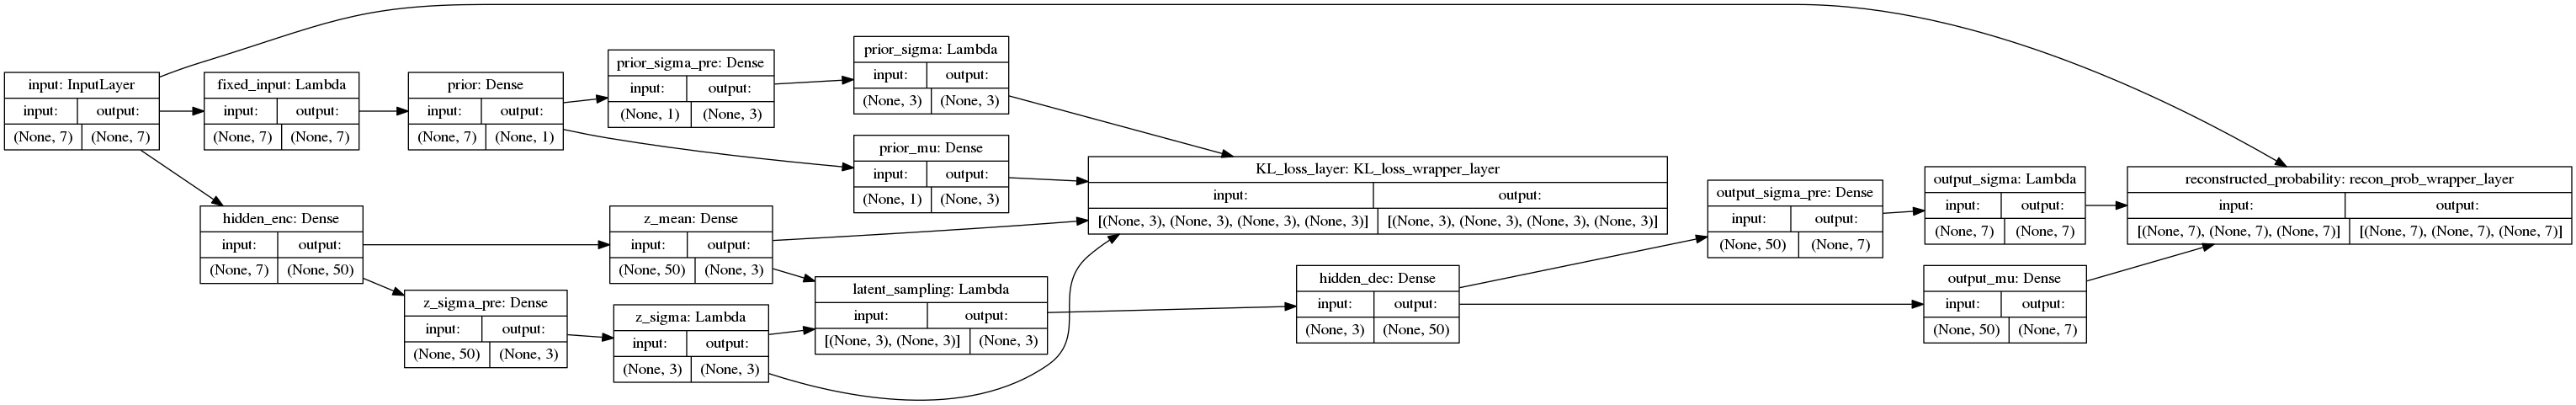

In [105]:
instance = trainer.trainer(os.path.join(model_path, name))
instance.remove(True)

h5_elt 'metric_names' :: creating group 'data' in file 'bn_7_v1.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'bn_7_v1.h5'
h5_elt 'training' :: creating group 'params' in file 'bn_7_v1.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'bn_7_v1.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'bn_7_v1.h5'
train_shell :: removed associated data files for self!


In [103]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)


autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss='mse',
    epochs=10,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=128,
    use_callbacks=True,
    learning_rate=0.005
)

Train on 77562 samples, validate on 25854 samples
Epoch 1/10
605/605 [==============================] - 13s 22ms/step - loss: 1.9136 - r_square: -0.0142 - mean_absolute_error: 0.7990 - mean_squared_error: 1.0142 - val_loss: 0.9981 - val_r_square: -2.8610e-06 - val_mean_absolute_error: 0.7927 - val_mean_squared_error: 0.9981
Epoch 2/10
605/605 [==============================] - 13s 21ms/step - loss: 1.0000 - r_square: 1.4218e-06 - mean_absolute_error: 0.7945 - mean_squared_error: 1.0000 - val_loss: 0.9981 - val_r_square: -2.7418e-06 - val_mean_absolute_error: 0.7927 - val_mean_squared_error: 0.9981
Epoch 3/10
605/605 [==============================] - 13s 21ms/step - loss: 1.0000 - r_square: 1.1625e-08 - mean_absolute_error: 0.7945 - mean_squared_error: 1.0000 - val_loss: 0.9981 - val_r_square: -2.5034e-06 - val_mean_absolute_error: 0.7927 - val_mean_squared_error: 0.9981
Epoch 4/10
451/605 [=====================>........] - ETA: 3s - loss: 1.0000 - r_square: 0.0000e+00 - mean_absolute_

KeyboardInterrupt: 

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

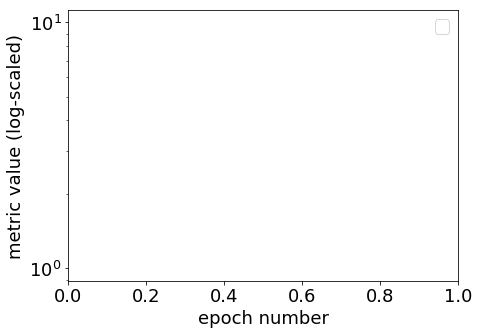

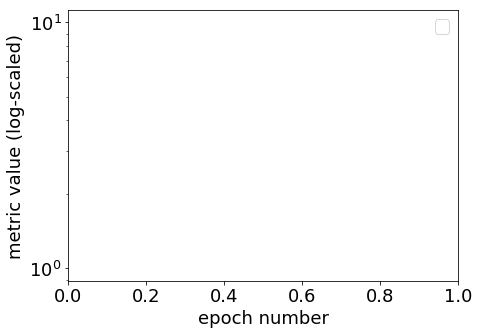

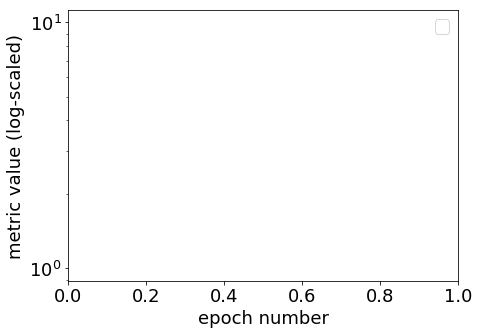

In [104]:
# instance.plot_metrics(fnmatch_criteria="*loss*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="log")

checking results:

In [88]:
# encoder, decoder = autoencoder.layers[1:]
# data_neck, signal_neck = encoder.predict(data_norm.data), encoder.predict(signal_norm.data) 

errors, recon = utils.get_recon_errors([train_norm, test_norm, data_norm, signal_norm], autoencoder, functions=['mse', 'mae', r_square_np], names=[None, None, "r-square"])
(train_err, test_err, data_err, signal_err) = errors
(train_recon, test_recon, data_recon, signal_recon) = recon



In [78]:
# plt.hist(np.sum(np.isclose(data_neck, 0), axis=1), bins=bn, range=(0,bn))
# plt.show()

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train'", "'background' normed to 'train' pred"]


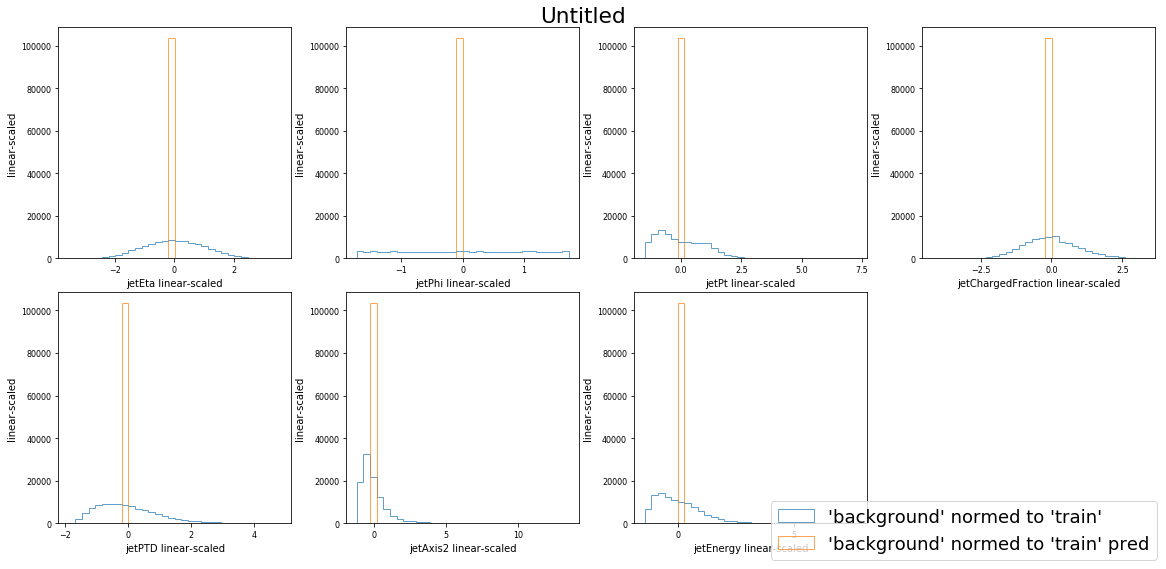

data_table :: plotting distrubution(s) for table(s) ["'signal' normed to 'train'", "'signal' normed to 'train' pred"]


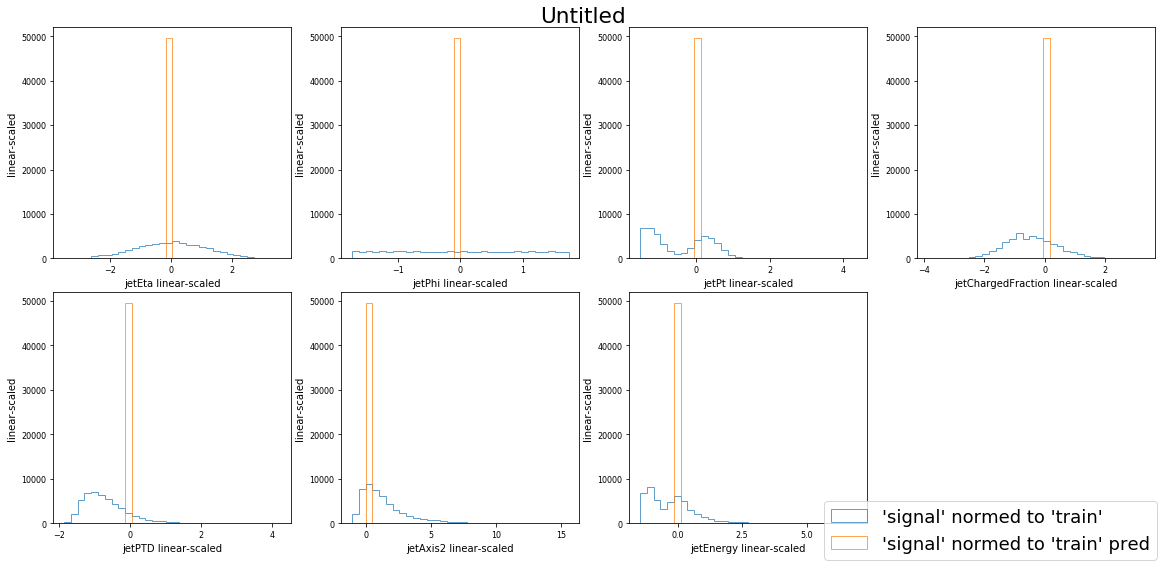

In [89]:
data_norm.plot(data_recon, normed=0)
signal_norm.plot(signal_recon, normed=0)

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train' error", "'signal' normed to 'train' error"]


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


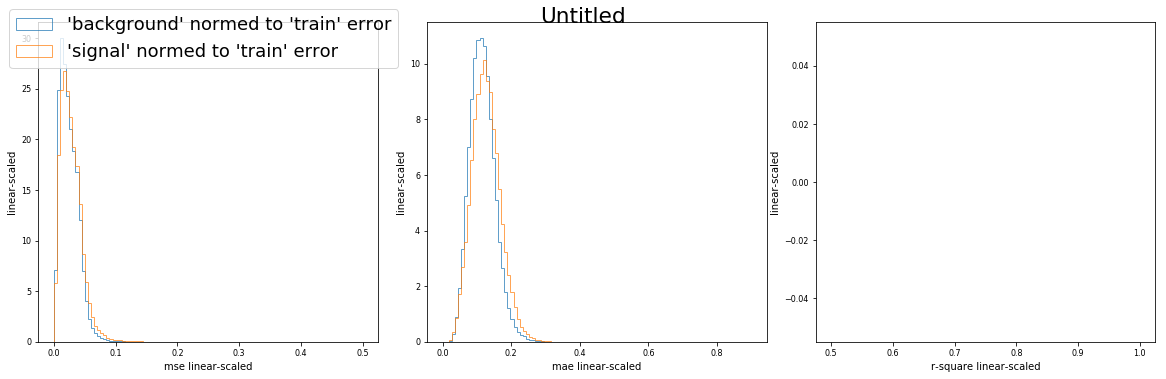

auc value: 0.576535817983


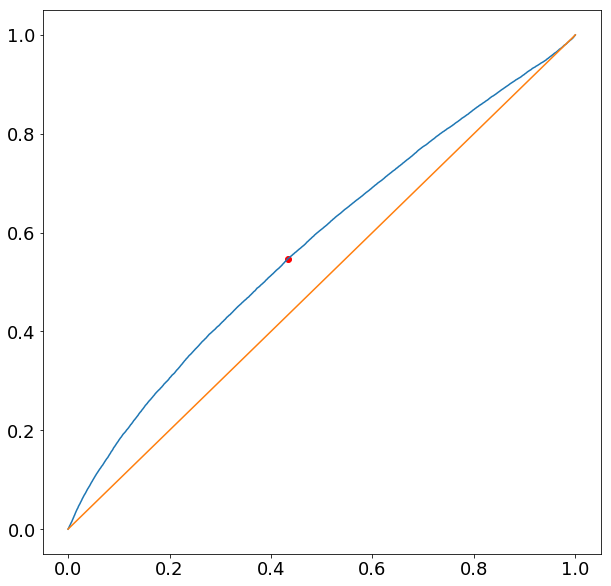

In [16]:
data_err.plot(signal_err, figloc="upper left", bins=100, rng=((0,.5), (0, 0.9), (0.5, 1.)), normed=1)

def roc_auc_plot(data_err, signal_err, metric='mae'):
    from sklearn.metrics import roc_curve, roc_auc_score
    pred = np.hstack([signal_err[metric].values, data_err[metric].values])
    true = np.hstack([np.ones(signal_err.shape[0]), np.zeros(data_err.shape[0])])

    roc = roc_curve(true, pred)
    auc = roc_auc_score(true, pred)
    print "auc value:", auc
    plt.figure(figsize=(10,10))
    # ax = fig.axes() 
    plt.plot(roc[0], roc[1])
    plt.plot((0,1), (0,1))
    roc_dict = {"roc": roc, "auc": auc}
    
    fpr, tpr, _ = roc_dict['roc']
    argmin = np.argsort(np.sqrt(fpr**2. + (1. - tpr)**2.))[0]
#     print fpr[argmin], tpr[argmin]
    plt.scatter(fpr[argmin], tpr[argmin], c='r')
    
    plt.show()
    
    return roc_dict

roc_dict = roc_auc_plot(data_err, signal_err, 'mae')

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


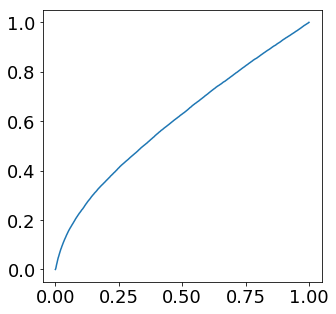

In [121]:
plt.figure(figsize=(5,5))
plt.plot(x,y)
deriv = np.diff(y)/np.diff(x)

plt.plot(x[1:], deriv, c='r')
plt.show()

In [128]:
np.isclose(np.diff(x), 0).shape

(63867,)

In [112]:
y/x

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


array([        nan,  0.        ,  2.08853704, ...,  0.99997895,
        1.00001934,  1.        ])

In [39]:
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=40,
#     rng=((0,0.1), (0, 0.25), (.85,1)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="linear",
#     histtype="step",
#     alpha=1
# )
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=40,
#     rng=((0,0.3), (0, 0.5), (.5,1)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="log",
#     histtype="step",
#     alpha=1
# )
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=20,
#     rng=((.1,0.3), (.12, 0.5), (.5,.9)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="linear",
#     histtype="step",
#     alpha=1
# )